In [ ]:
## Import Libraries

import pandas as pd
import numpy as np

import pickle
import matplotlib.pyplot as plt
import importlib
import os

#BiogasModel Modules

import Transportation_moduleOptA3 as tm
import VisualizationModule as vm
import SystemModel         as sm

from geobr import read_municipality

importlib.reload(vm)

## Load GeoBR data

MuniGeom = read_municipality(code_muni="all", year=2018)


/Users/cristianjunge/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [ ]:
MuniGeom

In [4]:
## Define root and runs folders

root = '/Users/cristianjunge/OneDrive/BiogasModel'

runs = 'Runs_cianorte'

## Loading results

os.chdir(os.path.expanduser(root))

muniscope = pd.read_excel('{}/1_RunsSetup/MuniScope.xlsx'.format(runs))
muniscopeID = list(muniscope.MuniID)

#centroids_dict,MuniGeom_select = vm.get_muni_centroids(MuniGeom,muniscopeID)

result_files = [f for f in os.listdir('{}/2_Output'.format(runs)) if 'pkl' in f]
runs_results = {}

print('List of results in directory: \n')
for r in result_files:
    print(r)
    runs_results[r] = pickle.load( open( "{}/2_Output/{}".format(runs,r), "rb" ) )

## Load parameters

ImpactParameters0 = pd.read_csv('{}/0_InputData/Financial Module Data A4.csv'.format(runs))

MuniDistances     =  pd.read_csv('{}/0_InputData/Muni_centroids_distances_km_code_muni.csv'.format(runs),index_col=0)

BioParameters     = pd.read_csv('{}/0_InputData/Biodigester module data.csv'.format(runs),index_col=0)

Supply            = pd.DataFrame(BioParameters.loc[:,'Manure generated (kg/day)'])


List of results in directory: 

LambdaOut_0.25.pkl
LambdaOut_0.5.pkl
LambdaOut_0.0.pkl


In [5]:
## Select result to analyze:

result = 'LambdaOut_0.5.pkl'

## Compute model outcomes:

DesignVector = runs_results[result]['x_best']

BioParameters   = BioParameters.loc[muniscopeID,:]

Supply          = Supply.loc[muniscopeID,:]

SortedDistances = tm.SortedDistancesDict(MuniDistances,muniscopeID)

parameters = (Supply,SortedDistances, BioParameters, ImpactParameters0)

annual_net_income,Costs_tup,rev_dict,MovementsKg,net_co2_offset_kg_per_year = sm.BioGasModel(DesignVector,*parameters)
Supply.columns = ['Supply0']
print('Done!')

print('Net Income:',round(annual_net_income,0))
print('CO2 Offset:',round(net_co2_offset_kg_per_year,0))


(11, 11)
Done!
Net Income: 447776582.0
CO2 Offset: 3748201246.0


# Paralell Axis Plot

Manure collected: 99.2%
Net Income: R$ 42.47/kg


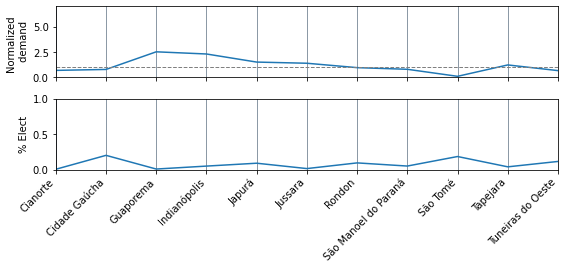

In [6]:
plot_name = 'Municipality_analysis'

importlib.reload(vm)

fig,axs = plt.subplots(2,1,figsize=(9,3))

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

norm_dv =  vm.normalize_dv(DesignVector,Supply)

norm_dv = vm.DV2Array(norm_dv)

labels  = list(muniscope.name_muni_IBGE)

dv_demand = norm_dv[0:len(norm_dv)//2]
dv_fract  = norm_dv[len(norm_dv)//2:]

axs[0].plot(range(1,len(dv_demand)+1),dv_demand,label = 'Design1')
axs[0].plot(range(1,len(dv_demand)+1),np.ones(len(dv_demand)),'--', linewidth=1,color = 'grey')

axs[1].plot(range(1,len(dv_fract)+1),dv_fract,label = 'Design1')

axs[0].set_xlim([1,len(dv_demand)])
axs[1].set_xlim([1,len(dv_fract)])

axs[0].set_xticks(np.arange(1,len(dv_demand)+1))
axs[1].set_xticks(np.arange(1,len(dv_fract)+1))

axs[0].set_ylim([0,7])
axs[1].set_ylim([0,1])

axs[0].grid(color='slategrey', linestyle='-', linewidth=0.8,axis = 'x')
axs[1].grid(color='slategrey', linestyle='-', linewidth=0.8,axis = 'x')

axs[0].xaxis.set_ticklabels([])
axs[1].xaxis.set_ticklabels(labels, rotation = 45, ha='right', minor=False)

axs[0].set_ylabel('Normalized \n demand')
axs[1].set_ylabel('% Elect')

print('Manure collected: {}%'.format(round(DesignVector['Demand0'].sum()/Supply['Supply0'].sum()*100,1)))
print('Net Income: R$ {}/kg'.format(round(annual_net_income/DesignVector['Demand0'].sum(),2)))

save = 'n'

save = 'y'
if save == 'y':
    plt.savefig('{}/3_Visuals/{}_{}_Paralell.pdf'.format(runs,plot_name,result), bbox_inches='tight')


# Manure Movements Plot

/Users/cristianjunge/OneDrive/BiogasModel/Post_processing/VisualizationModule.py:161: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(ticks_round)


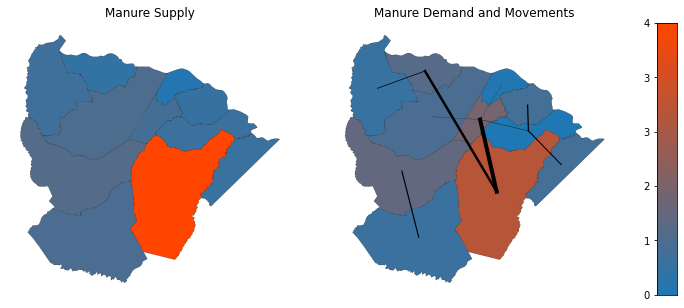

In [17]:
# Plot Supply and Demand

plot_name = 'Manure_Movements'
fig,ax = plt.subplots(1,3,figsize=(12,5),
                       gridspec_kw={'width_ratios': [1,1, 0.07]},
                       )
Demand = pd.DataFrame(DesignVector['Demand0'])

vm.plotSolution(MuniGeom_select,
                    centroids_dict,
                    BioParameters,
                    Demand,
                    MovementsKg,ax)

save = 'n'

if save == 'y':
    
    plt.savefig('{}/3_Visuals/{}_{}_Map.pdf'.format(runs,plot_name,result), bbox_inches='tight')
